# Анализ и обработка данных одного куста

## Импорт библиотек

In [1]:
#from scipy.signal import savgol_filter
#import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from pandas.plotting import autocorrelation_plot

import sys
sys.path.append('custom_modules')

import Data_processing as dp
import Data_visualization as dv

## Константы 

In [2]:
# путь к файлу Excel
path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 201\Скважина 2011.xlsx'
#path_to_data = 'Data\Данные СТМ Восточный Купол (от 29.01.17)\Куст 202\Скважина 2022.xlsx'

## Описание принципа обработки данных

В рамках подготовки данных было решено сделать следующие вычисления:
1. Удалить пропуски в данных (стоки датафрейма/таблицы где отсутствует хотя бы 1 значение)
2. Удалить строки датафрейма/таблицы где хотя бы у одного элемента значение равняется 0, так как такие значения классифицируются как отсутствие сигнала от прибора из-за того, что о выключен
3. Удалить выбросов в данных.
4. Удалить шумы из данных (предположительно белый шум)

Для удаления выбросов был выбран метод IQR

(Википедия, англ) The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.
<a>https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba<\>


(Перевод) Межквартильный размах, также называемый межквартильным диапозоном или средним от 50% (формально H-распространение)в статистике - это мера дисперсии, равная разнице между 75% и 25% процентилями, или между нижним и верхним квартилем. Формула для расчета через квартили - IQR = Q3 - Q1.
    
Другими словами IQR - это разность 3 и 1 квартилей, а значения самих квартилей можно увидеть на диаграмме ящика с усами для исследуемых данных.
    
Эта мера идентична стандартному отклонению переменной, однако намного устойчивее к выбросам.

Идея метода - определение правой и левой границ ряда чисел между которыми находятся наиболее вероятные/часто встречаемые числа, а за их пределами числа, встречающиеся реже. Таким образом числа не входящие в диапазон считаются выбросами и удаляются или обрабатываются соответствующим образом.

В данной реализации первый квартиль расчитывался для 2,5%, а третий для 97,5%. Значения выбраны эмпирически. Значения границ высчитывались по формулам:
    
Q1-1.5*IQR - для левой границы;
    
Q3+1.5*IQR - для правой границы.
    
Формулы взяты из статьи выше.

# Исследование данных до обработки

In [3]:
# чтение данных и приведение столбцов к нужным типам данных
first_df = dp.get_df(path_to_data)

In [4]:
# Общее описание данных до подготовки
dv.describe_data(first_df)

\\\\\\\\\\\\\Общий вид датафрейма


,Time Moment,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
1,2014-12-11 00:00:00,116.536697,112.045097,46.856258,55716.488281
2,2014-12-11 02:00:00,115.591301,112.103897,46.859692,55215.261719
3,2014-12-11 04:00:00,115.929298,112.182198,46.880291,55229.570312
4,2014-12-11 06:00:00,116.546501,112.275299,46.918060,55462.929688
5,2014-12-11 08:00:00,116.198700,112.329201,46.918060,55315.988281
...,...,...,...,...,...
9357,2017-01-28 16:00:00,82.166397,82.470093,45.321579,22623.039062
9358,2017-01-28 18:00:00,82.132118,82.445587,45.163651,22638.109375
9359,2017-01-28 20:00:00,82.318237,82.612129,45.187691,22611.640625
9360,2017-01-28 22:00:00,82.337837,82.631721,45.249489,22575.789062


\\\\\\\\\\\\\Список типов столбцов

 Time Moment                             object
PT2011-202 (Давление до УР)            float64
PT2011-204 (Давление после УР)         float64
TT2011-101 (Температура в ТП до УР)    float64
FT2011-301-1 (Расход в ТП до УР)       float64
dtype: object
\\\\\\\\\\\\\Общее описание данных


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
count,9292.000000,9292.000000,9292.000000,9292.000000
mean,106.055068,104.252704,47.489140,31441.511229
std,18.184290,13.657690,3.805488,9277.163173
min,-0.421241,-0.308583,-50.000000,0.000000
25%,99.074799,99.873009,46.904320,25154.277344
50%,108.768200,107.898849,48.095680,27602.485352
75%,114.137823,112.157799,48.861301,37332.399414
max,173.482498,162.270706,50.231178,127115.898438


\\\\\\\\\\\\\Таблица коэффициентов корреляции


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
PT2011-202 (Давление до УР),1.000000,0.764838,0.466869,0.583759
PT2011-204 (Давление после УР),0.764838,1.000000,0.545340,0.523507
TT2011-101 (Температура в ТП до УР),0.466869,0.545340,1.000000,0.435089
FT2011-301-1 (Расход в ТП до УР),0.583759,0.523507,0.435089,1.000000


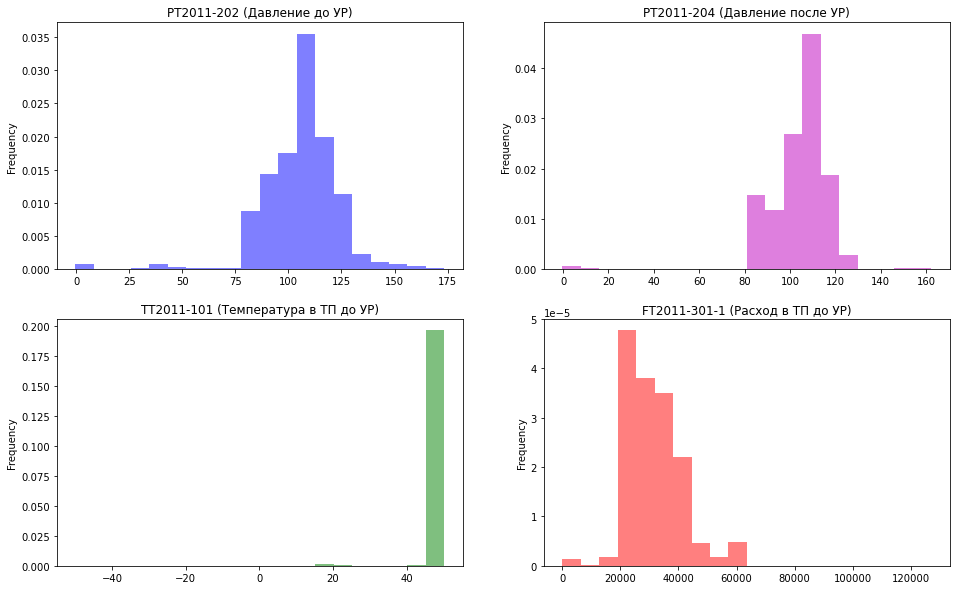

In [5]:
# Частота встречающихся значений для данных до подготовки
dv.draw_4_frewuencis_graphs(first_df)

Размер датасета:
до обработки:  (9361, 5) 
после:  (9292, 5) 
удалено строк:  69


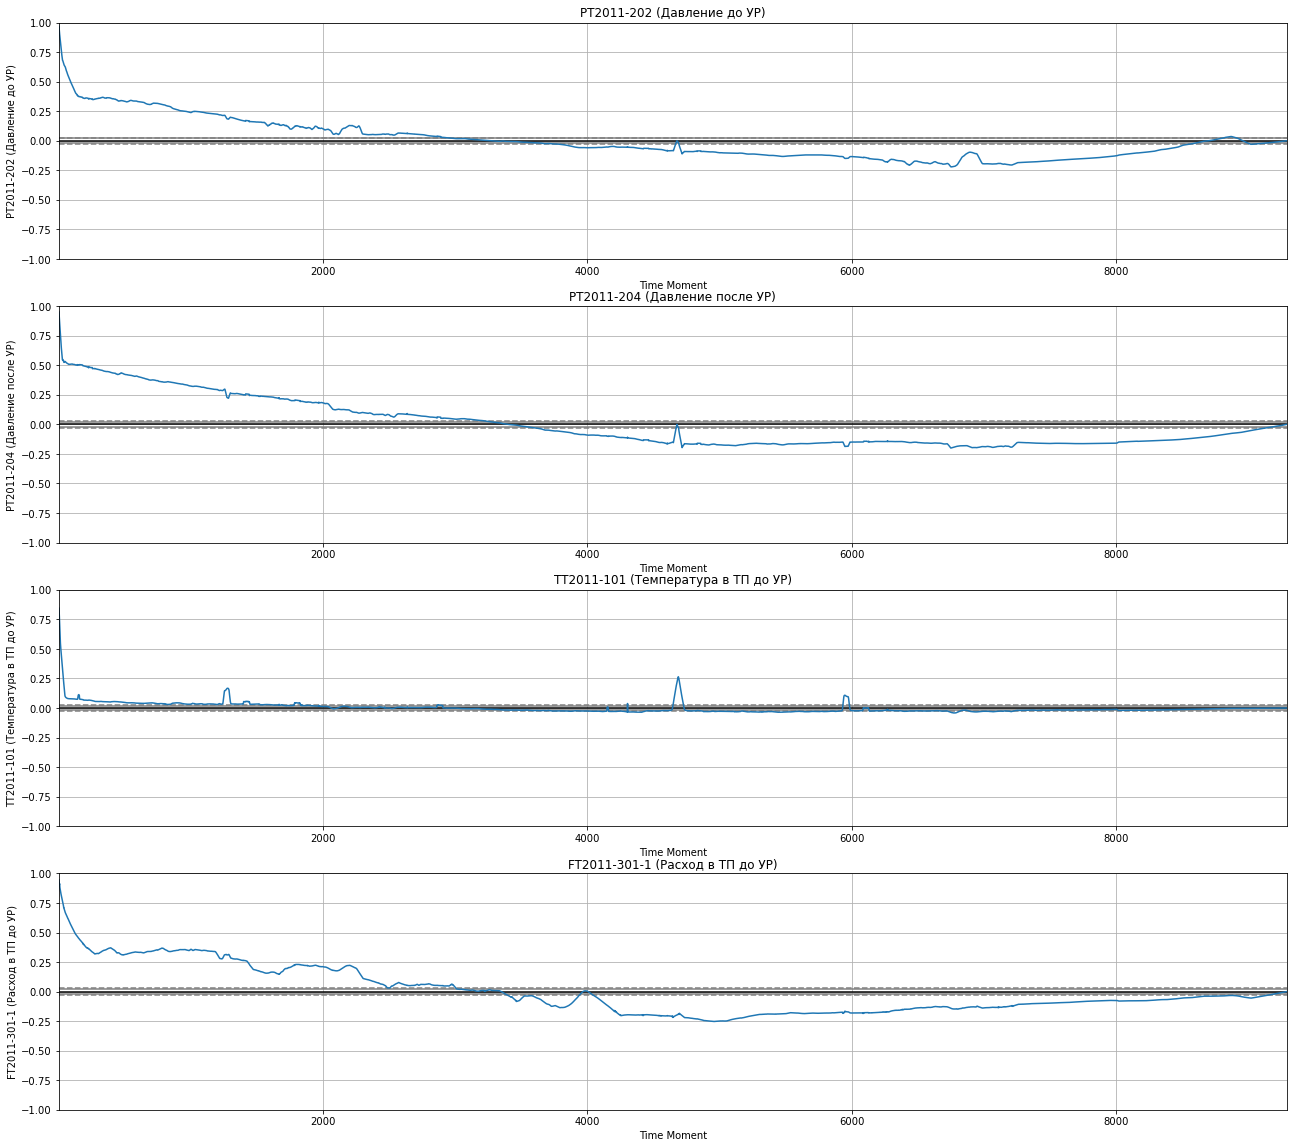

In [6]:
# вывести 4 графика автокорреляции (по графику на столбец) для необработанных данных
# тут у датафрейма все-равно удаляются NAN значения, ибо с ними этот график не рисуется
dv.draw_4_autocorrelation_graphs(dp.delete_NANs(first_df))

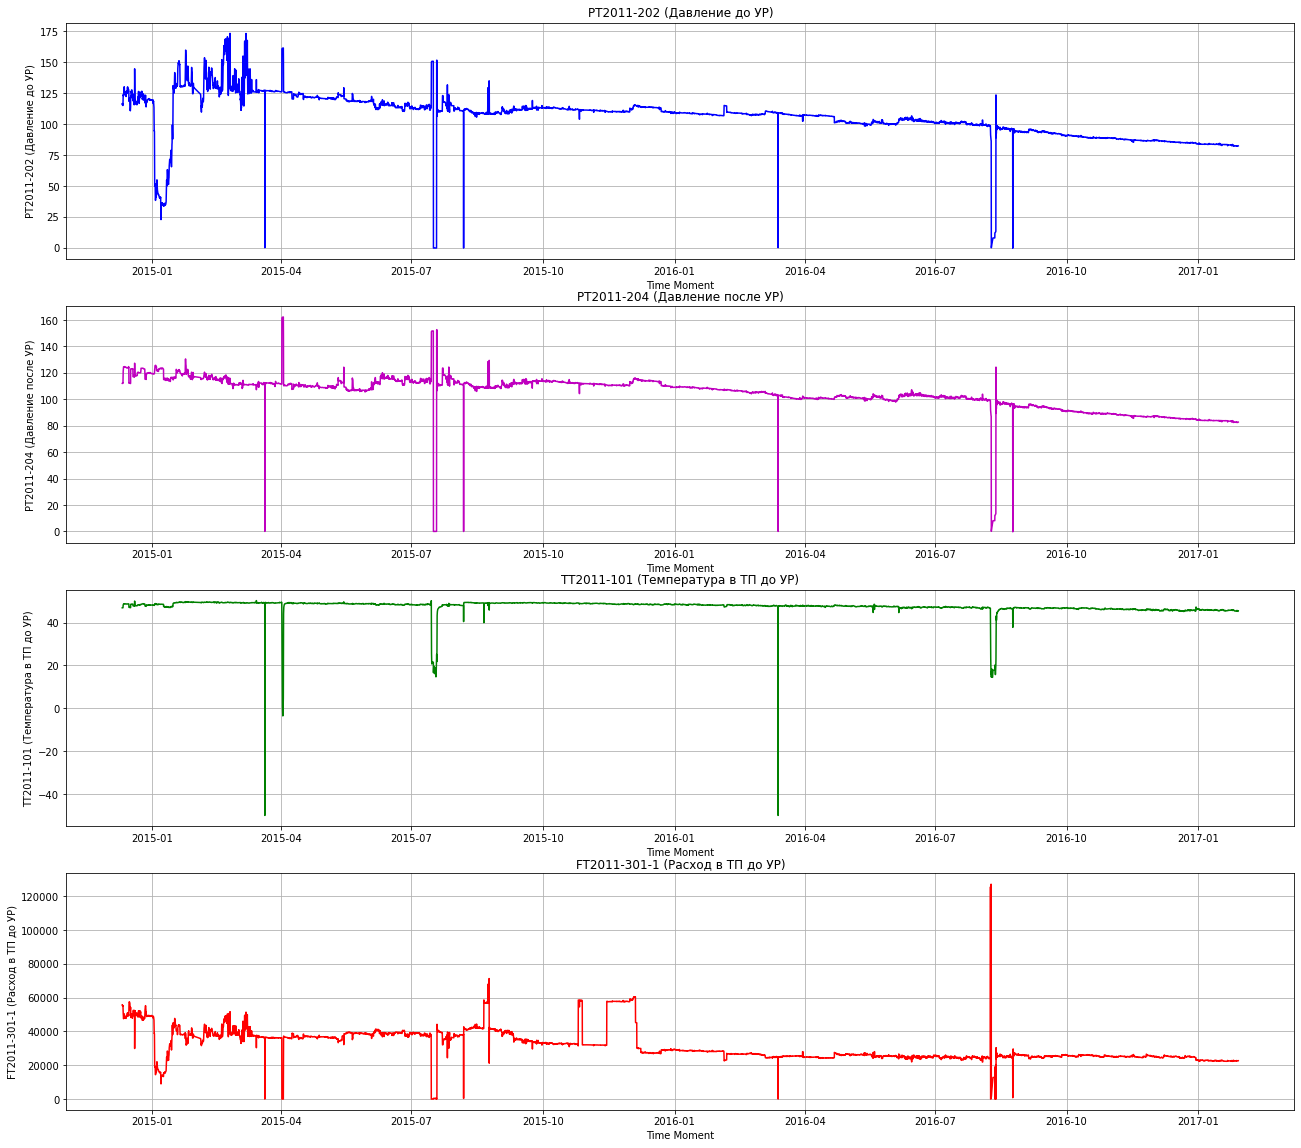

In [7]:
# визуализация данных до подготовки
dv.draw_4_graphs(first_df)

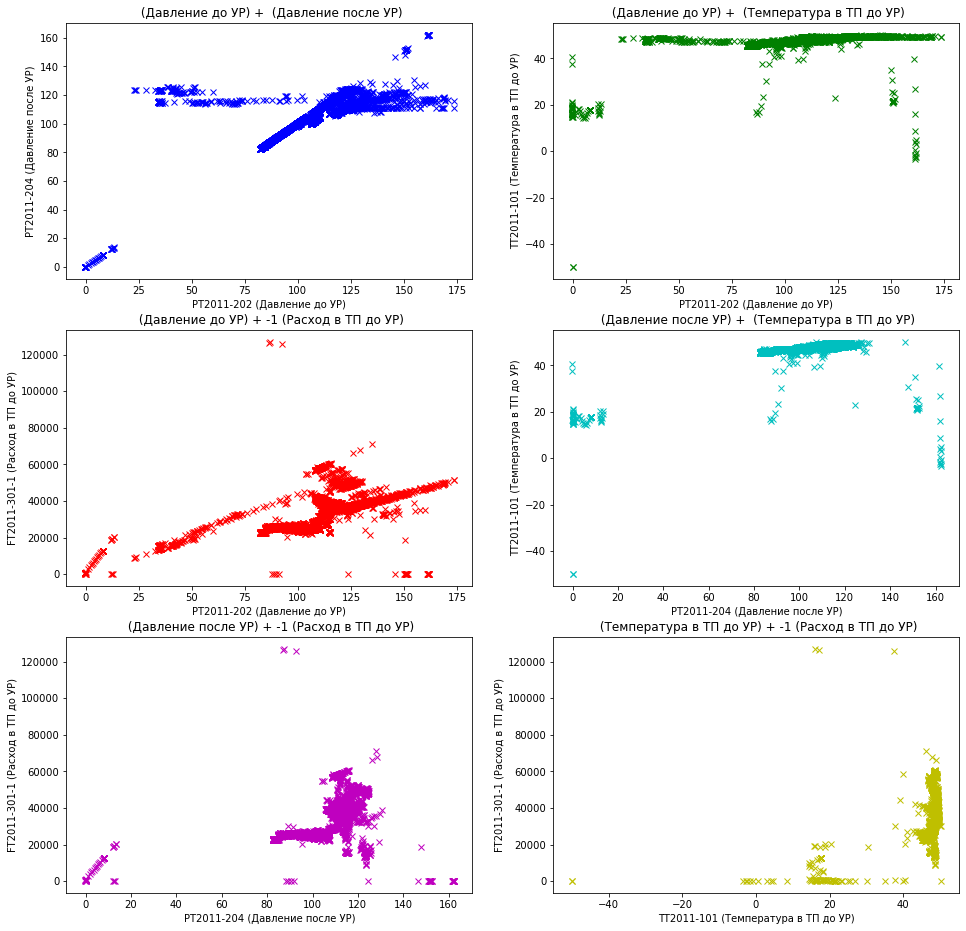

In [8]:
# вывод графиков отношений столбцов датафрейма без повторений для не подготовленных данных 
dv.draw_6_relations_graphs(first_df)

# Обработка данных

In [9]:
# Удаление нулевых значений
prepared_df = dp.delete_zeros(first_df)

Размер датасета:
до обработки:  (9292, 5) 
после:  (9280, 5) 
удалено строк:  12


In [10]:
# Удаление пропусков данных
prepared_df = dp.delete_NANs(prepared_df)

Размер датасета:
до обработки:  (9280, 5) 
после:  (9280, 5) 
удалено строк:  0


In [11]:
# Удаление выбросов
prepared_df = dp.delete_outliers(prepared_df, soft_mode = True)


	Фильтрация по:  PT2011-202 (Давление до УР)
	Удалено строк:  33 


	Фильтрация по:  PT2011-204 (Давление после УР)
	Удалено строк:  35 


	Фильтрация по:  TT2011-101 (Температура в ТП до УР)
	Удалено строк:  33 


	Фильтрация по:  FT2011-301-1 (Расход в ТП до УР)
	Удалено строк:  0 

Размер датасета:
до обработки:  (9280, 5) 
после:  (9179, 5) 
удалено строк:  101


## Исследование данных после обработки

In [12]:
# Общее описание данных до подготовки
dv.describe_data(prepared_df)

\\\\\\\\\\\\\Общий вид датафрейма


,Time Moment,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
1,2014-12-11 00:00:00,116.536697,112.045097,46.856258,55716.488281
2,2014-12-11 02:00:00,115.591301,112.103897,46.859692,55215.261719
3,2014-12-11 04:00:00,115.929298,112.182198,46.880291,55229.570312
4,2014-12-11 06:00:00,116.546501,112.275299,46.918060,55462.929688
5,2014-12-11 08:00:00,116.198700,112.329201,46.918060,55315.988281
...,...,...,...,...,...
9357,2017-01-28 16:00:00,82.166397,82.470093,45.321579,22623.039062
9358,2017-01-28 18:00:00,82.132118,82.445587,45.163651,22638.109375
9359,2017-01-28 20:00:00,82.318237,82.612129,45.187691,22611.640625
9360,2017-01-28 22:00:00,82.337837,82.631721,45.249489,22575.789062


\\\\\\\\\\\\\Список типов столбцов

 Time Moment                             object
PT2011-202 (Давление до УР)            float64
PT2011-204 (Давление после УР)         float64
TT2011-101 (Температура в ТП до УР)    float64
FT2011-301-1 (Расход в ТП до УР)       float64
dtype: object
\\\\\\\\\\\\\Общее описание данных


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
count,9179.000000,9179.000000,9179.000000,9179.000000
mean,106.670486,104.841485,47.865280,31729.839687
std,15.684636,10.119691,1.154550,8653.859733
min,22.737190,82.406410,39.886700,5.582912
25%,99.417671,99.968712,46.959259,25184.344727
50%,108.827003,107.984497,48.112839,28156.089844
75%,114.114548,112.152901,48.868160,37395.580078
max,173.482498,161.286194,50.231178,71294.703125


\\\\\\\\\\\\\Таблица коэффициентов корреляции


,PT2011-202 (Давление до УР),PT2011-204 (Давление после УР),TT2011-101 (Температура в ТП до УР),FT2011-301-1 (Расход в ТП до УР)
PT2011-202 (Давление до УР),1.000000,0.659914,0.732909,0.629698
PT2011-204 (Давление после УР),0.659914,1.000000,0.862881,0.611637
TT2011-101 (Температура в ТП до УР),0.732909,0.862881,1.000000,0.613607
FT2011-301-1 (Расход в ТП до УР),0.629698,0.611637,0.613607,1.000000


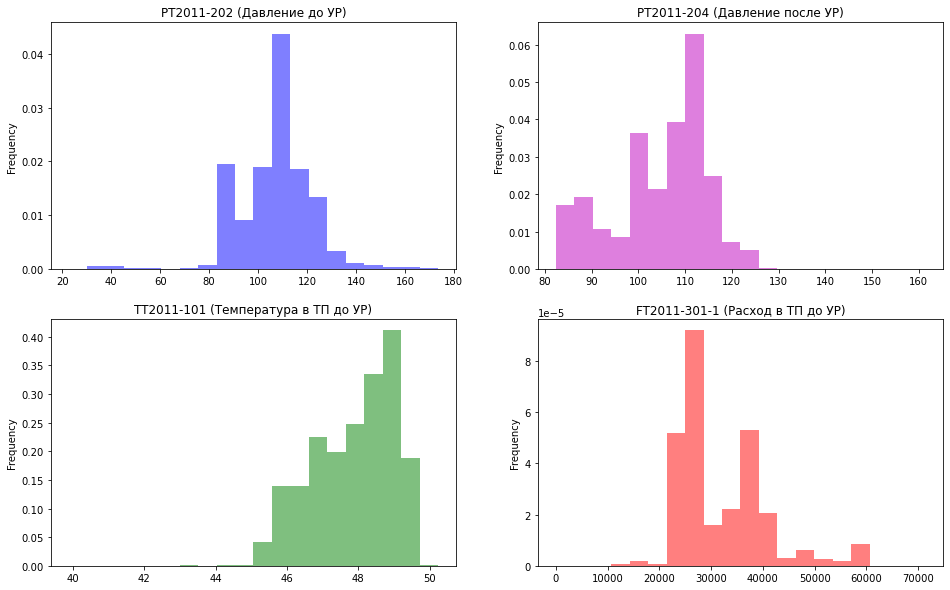

In [13]:
# Частота встречающихся значений для подготовленых данных
dv.draw_4_frewuencis_graphs(prepared_df)

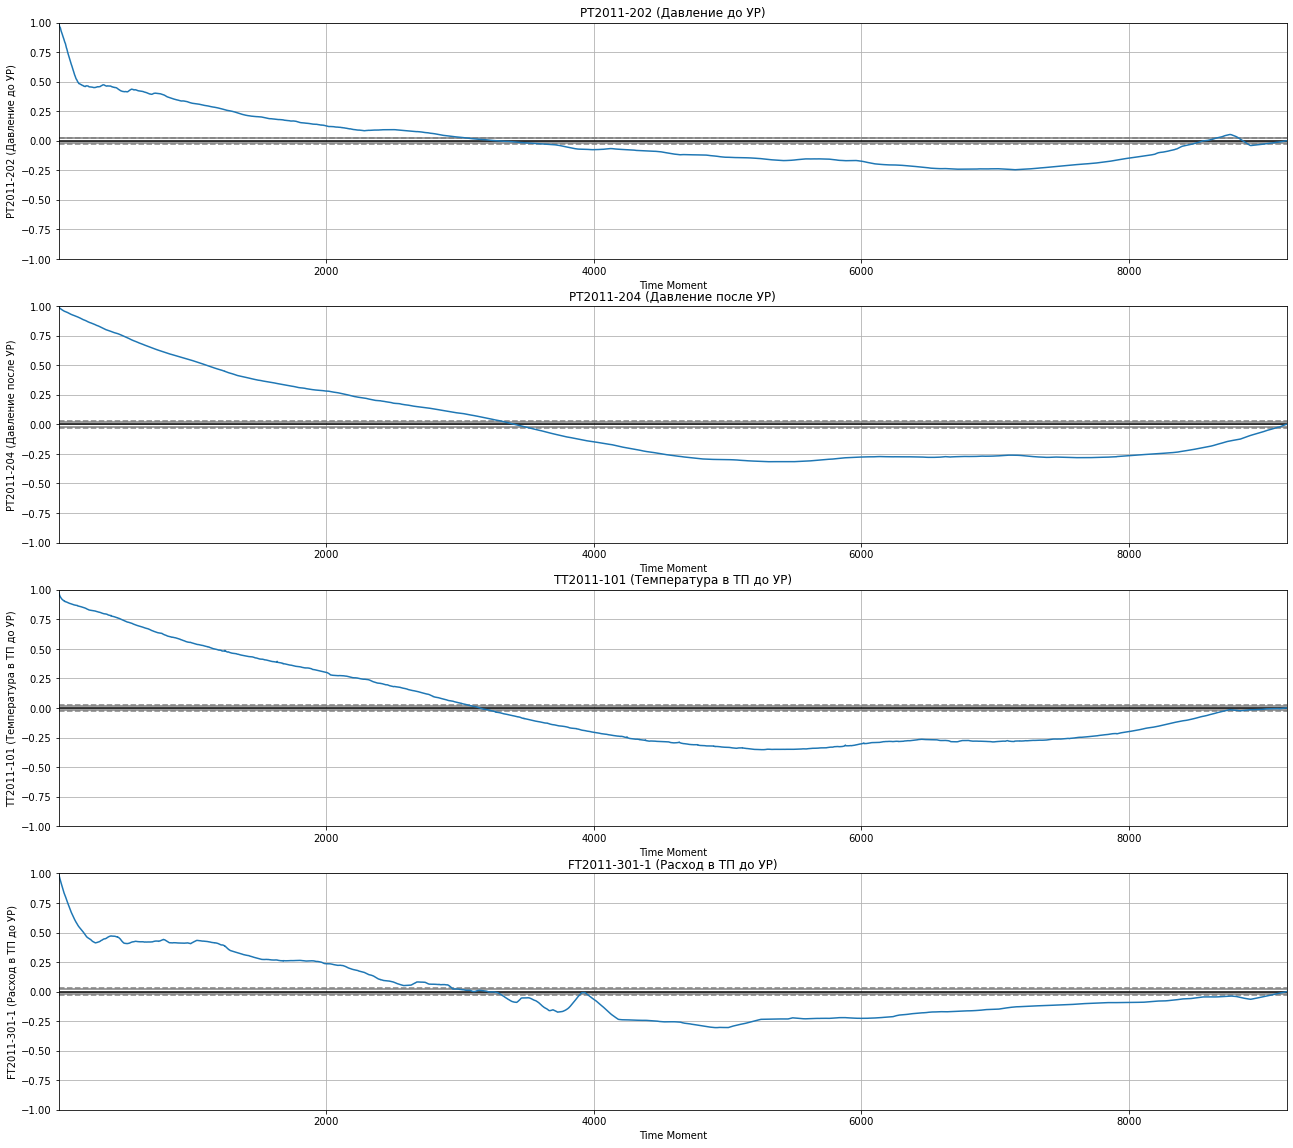

In [14]:
# вывести 4 графика автокорреляции (по графику на столбец) для обработанных данных
dv.draw_4_autocorrelation_graphs(prepared_df)

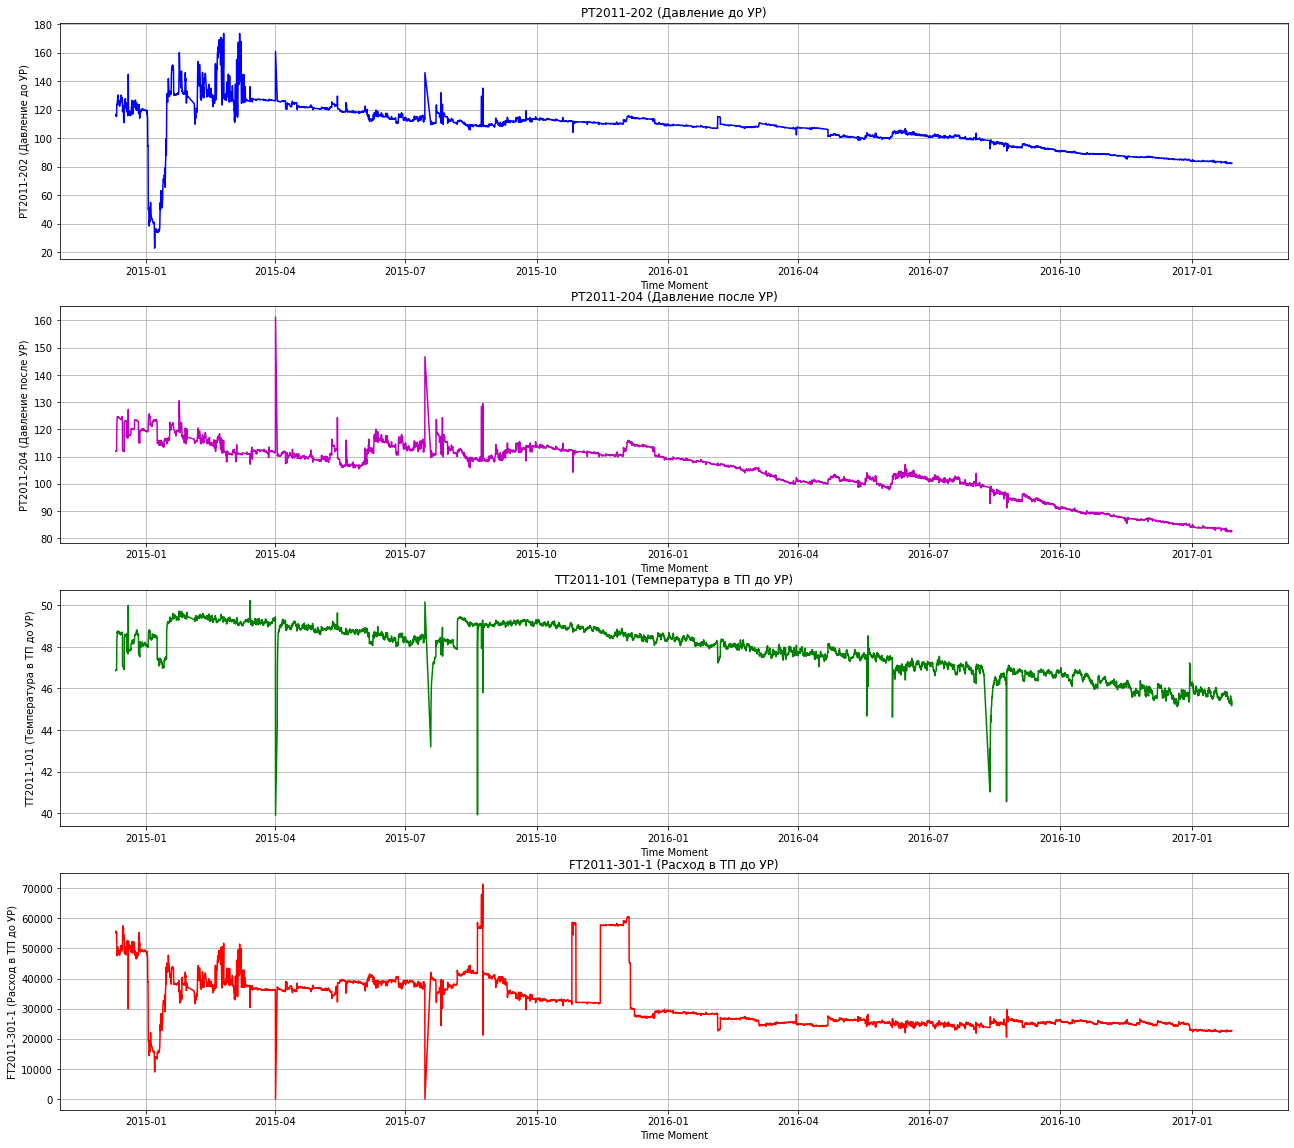

In [15]:
# визуализация данных после подготовки
dv.draw_4_graphs(prepared_df)

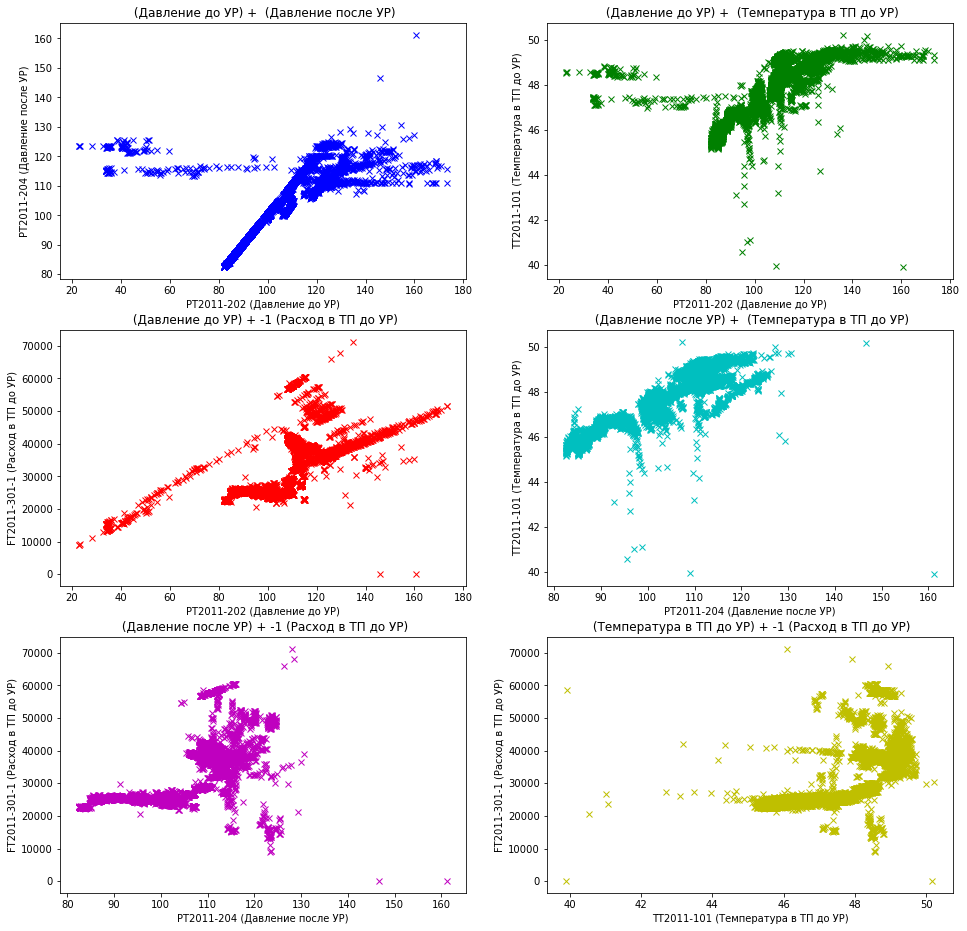

In [16]:
# вывод графиков отношений столбцов датафрейма без повторений для подготовленных данных
dv.draw_6_relations_graphs(prepared_df)

# Наглядное сравнение обработанных данных с начальными

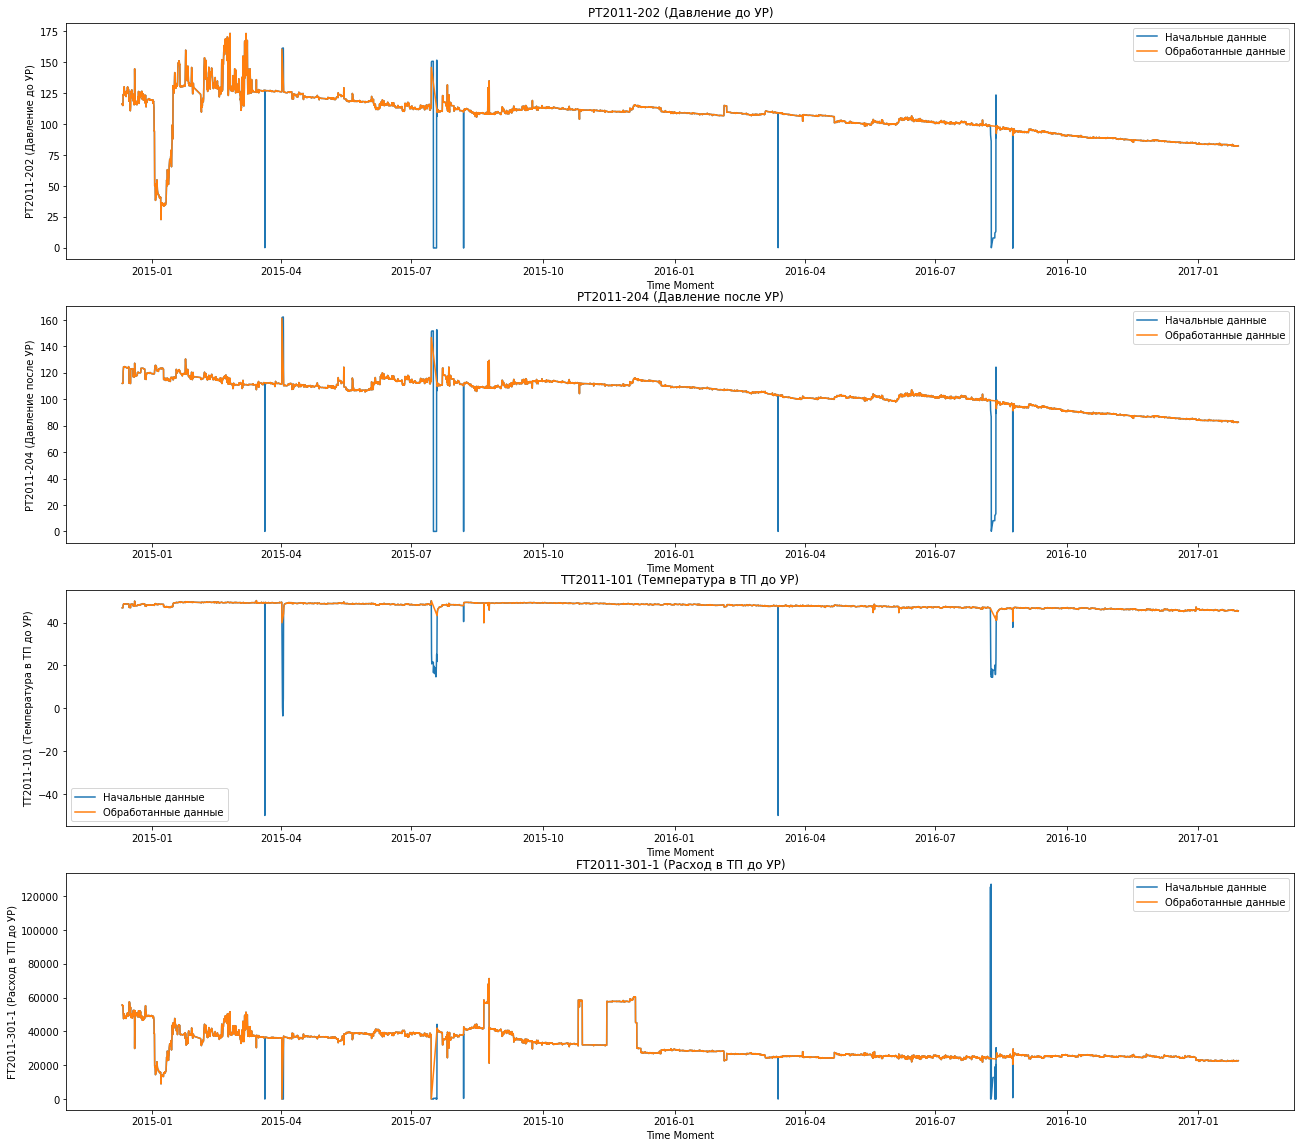

In [17]:
# вывод графиков для сравнения подготовленных данных и начальных (данные относительно времени по столбцам)
dv.draw_4_graphs_with_overlay_for_2_df(first_df, prepared_df)

# Выводы

Основной вывод - пригодность данных к использованию в обучении после обработки возросла.

Смотрим на матрицу коэффициентов корреляции данных, видим, что

а) корреляция между всеми столбцами имеется

б) после обработки большинство коэффициентов выросли (скорее всего из-за уменьшения кол-ва выбросов)

(однако расчета доверительных интервалов для этих коэффов и выводов о их стат. значимости сделано не было).

Смотрим на гистограммы частот встречающихся значений, видим, что до обработки в данных были крайне редко встречающиеся значения, портящие общую картину (выбросы). Тот же график температуры - это 2 столба, один мелкий - выбросы, другой большой - все нормольные значения. После обработки (удаления редких значений считай) гистограммы стали выглядеть лучше, даже нормальное распределение напоминают.

Смотрим на коррелограммы, видим, что графики до обработки держатся довольно близко к нулю (а чем ближе к нулю, тем случайнее данные, как я понял), та же температура только редкими выбросами от нуля уходит. После обработки графики от этого нуля весомо отдалились (хотя мб такое поведение как раз выбросами и обусловлено ну или тем загадочным белым шумом).

Смотрим на графики параметров относительно времени до и после, видим, что до обработки температура за краткий временной промежуток может измениться от 40 до -40, хотя по идее должна делать это куда дольше и плавнее (после обработки самый большой скачек - от 49 до 40). Да и вообще по графику и не скажешь общую тенденцию, ибо большая его часть - горизонтальная линия. В целом, то же самое можно и о других сказать. После обработки данные стали выглядеть лучше.

Есть еще кляксообразные графики зависимостей каждой переменной от каждой, но по ним мало что можно сказать, разве что то, что в них можно условно разглядеть графики, описывающие общую тенденцию, что намекает на то, что разработка нейросети для работы с этими данными не совсем имеет смысл (кстати после обработки в графиках проще разглядеть тенденции).